# Re-calibration of a diffraction image with Jupyter

Jupyter notebooks (and jupyterlab) are standard tools to perfrom data analysis. 
While there are plenty of tutorial on the usage of pyFAI for azimuthal integration, few of then address the need for calculating the geometry of the experimental setup, also because the tool is not yet completely ready...

In this example we will perform the precise calibration of an image which setup is roughly known.

In [41]:
%matplotlib widget
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from pyFAI.gui import jupyter
import pyFAI
import fabio
from pyFAI.test.utilstest import UtilsTest
from pyFAI.calibrant import CALIBRANT_FACTORY
from pyFAI.goniometer import SingleGeometry
print(f"Using pyFAI version: {pyFAI.version}")
start_time = time.perf_counter()

Using pyFAI version: 0.20.0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

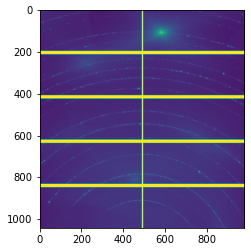

In [43]:
# In this example, we will re-use one of the image used int the test-suite
# filename = UtilsTest.getimage("Pilatus1M.edf")
filename = 'C:\\Users\\roberttk\\Desktop\\SLAC_RA\\DATA\\HiTp-11-21\\calib\\Scan3885-primary-pilatus1M_image-0.tiff'
frame = np.log(fabio.open(filename).data)
# and now display the image
plt.imshow(frame)

In [32]:
# This allow to measure approximatively the position of the beam center ...
x = 500 # x-coordinate of the beam-center in pixels
y = 1200 # y-coordinate of the beam-center in pixels
d = 250 # This is the distance in mm (unit used by Fit2d)
wl = 0.79e-10 # The wavelength is 1 Å

In [33]:
# Definition of the detector and of the calibrant:
pilatus = pyFAI.detector_factory("Pilatus1M")
behenate = CALIBRANT_FACTORY("LaB6")
behenate.wavelength = wl
behenate

LaB6 Calibrant with 94 reflections at wavelength 7.9e-11

In [34]:
# Set the guessed geometry
initial = pyFAI.geometry.Geometry(detector=pilatus, wavelength=wl)
initial.setFit2D(d,x,y)
initial

Detector Pilatus 1M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 7.900000e-11m
SampleDetDist= 2.500000e-01m	PONI= 2.064000e-01, 8.600000e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 250.000mm	Center: x=500.000, y=1200.000 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg

In [35]:
# The SingleGeometry object (from goniometer) allows to extract automatically ring and calibrate
sg = SingleGeometry("demo", frame, calibrant=behenate, detector=pilatus, geometry=initial)
sg.extract_cp(max_rings=5)

ControlPoints instance containing 5 group of point:
LaB6 Calibrant with 94 reflections at wavelength 7.9e-11
Containing 5 groups of points:
# p ring 0: 112 points
# q ring 1: 125 points
# r ring 2: 141 points
# s ring 3: 97 points
# t ring 4: 92 points

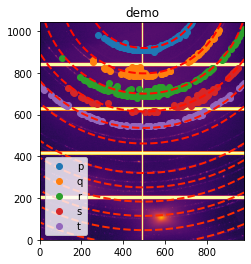

In [36]:
#Control point and rings do not overlap well initially (this was a guessed geometry)
ax = jupyter.display(sg=sg)

In [37]:
# Refine the geometry ... here in SAXS geometry, the rotation is fixed in orthogonal setup
sg.geometry_refinement.refine2(fix=["wavelength"])
sg.get_ai()

Detector Pilatus 1M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 7.900000e-11m
SampleDetDist= 2.647152e-01m	PONI= 1.580923e-01, 8.388867e-02m	rot1=-0.000583  rot2= 0.188215  rot3= 0.000000 rad
DirectBeamDist= 269.474mm	Center: x=488.622, y=1212.282 pix	Tilt=10.784 deg  tiltPlanRotation= 89.825 deg

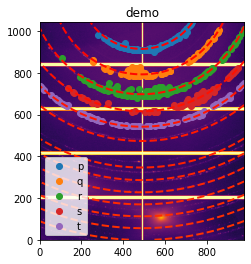

In [38]:
ax = jupyter.display(sg=sg)

In [39]:
#Save the geometry obtained
sg.geometry_refinement.save("geometry.poni")
with open("geometry.poni") as f:
    print(f.read())

# Nota: C-Order, 1 refers to the Y axis, 2 to the X axis 
# Calibration done at Tue Nov  9 09:42:11 2021
poni_version: 2
Detector: Pilatus1M
Detector_config: {}
Distance: 0.2647151920783149
Poni1: 0.1580923358298995
Poni2: 0.0838886729276283
Rot1: -0.0005830967888085985
Rot2: 0.18821470127721363
Rot3: 1.097188176321024e-09
Wavelength: 7.9e-11



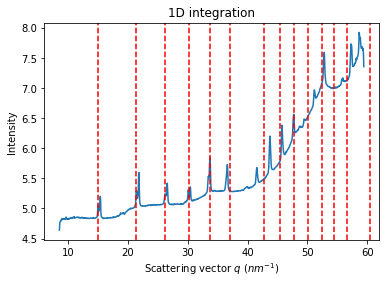

In [40]:
#Use the geometry to perform an azimuthal integration
ai = sg.get_ai()
res = ai.integrate1d(frame, 1000)
ax = jupyter.plot1d(res,calibrant=behenate)


## Conclusion

PyFAI still lacks some good integration into the Jupyter ecosystem, for example to draw a mask or pick control points, but it is nevertheless possible to calibrate an experimental setup when the approximate geometry is known.

In [12]:
print(f"Execution time: {time.perf_counter()-start_time:.3f} s")

Execution time: 3.975 s
